# Implement a custom Autoencoder with Koopman layer

## Version Control

Short Term To Do:
1) Implement models w/ dictionary of layer classes

Long Term To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Get Koopman operator, K
3) Preprocess Data
4) Make sure sim data is different for different ground parameters
5) Use static Koopman AE to train and get Koopman
6) Add a encoder model to get koopman eigenfunctions
7) Change training inference vs testing inference



## Setup

In [7]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time

In [8]:
# Import hyperparameter tuning
import keras_tuner as kt

In [9]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [19]:
#from google.colab import drive
#drive.mount('/gdrive')

## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [10]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',').values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',').values
discrete_val = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',').values

In [11]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train, tf.float32)
test_data = tf.cast(discrete_test, tf.float32)

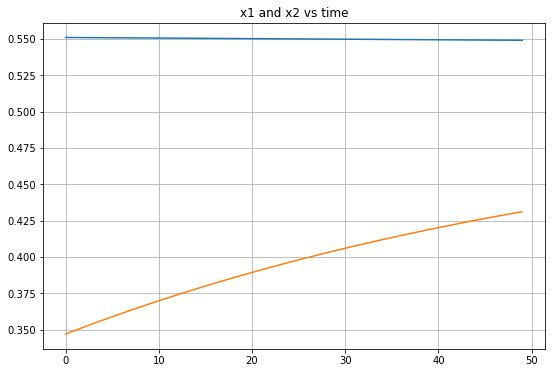

In [12]:
x_train = train_data[0:50,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

## Define the model

### Define Layer Class

In [13]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None, act='None'):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [14]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b

In [52]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_tilde: tensor
        return the forward time shifted Z
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj
        

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)
        
        # Find K
        K = tf.matmul(tf.transpose(Z2),tf.linalg.pinv(tf.transpose(Z1)))

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 indices = tf.constant([[traj*self.trajLength]])
                 if m == 0: 
                     updates = [tf.linalg.matvec(K, z1[0,:])]
                     tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    Ki = K
                    Ki = tf.matmul(Ki,K)
                    updates = [tf.linalg.matvec(Ki, z1[traj,:])]
                    tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                    
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(Z2-Z2_tilde))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))

        return Z, Z2_tilde

### Classes to Koopman AE

In [5]:
testVar = {}
testVar['test1'] = 1
testVar['test2'] = 2
testVar['test3'] = 3
for key,value in testVar.items():
    print(key, value)

test1 1
test2 2
test3 3


In [35]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder to take to lifted dimension w/ one output
    """
    def __init__(self, hp, name=None):
        """
        Initializes arbritrary layers of different unit size for encoder
        
        Parameter:
        ----------
        hp: Hyperparameter from keras
        name: String
            name of model
        """
        super(EncoderModel, self).__init__(name=name)
        self.encLayerLength = hp.Int("encLayerLength", min_value=3, max_value=5, step=1)
        self.encLayerDict = {}
        for i in range(self.encLayerLength):
            self.encLayerDict["encLayer" + str(i)] = EncoderLayer(hp.Choice("enc_units_"+str(i),[16, 32, 64]))

    def call(self, input):
        z = input # Final layer of encoder is in lifted dimension
        for key, val in self.encLayerDict.items():
            z = val(z)
        
        return z

In [38]:
class DecoderModel(keras.Model):
    """
    Custom Model to create an decoder w/ two outputs
    """
    def __init__(self, hp, outputDim=2, name=None):
        """
        Initializes arbritrary layers of different unit size
        
        Parameter:
        ----------
        hp: Hyperparameter from keras
        name: String
            name of model
        """
        super(DecoderModel, self).__init__(name=name)
        self.decLayerLength = hp.Int("decLayerLength", min_value=3, max_value=5, step=1)
        self.decLayerDict = {}
        for i in range(self.decLayerLength):
            self.decLayerDict["decLayer" + str(i)] = DecoderLayer(hp.Choice("dec_units_"+str(i),[16, 32, 64]))
        self.outputLayer = DecoderLayer(outputDim, name="dec_output_layer") # Specify output dimension

    def call(self, z, z2_tilde):
        x_hat = z # Input for reconstruction
        x2_hat = z2_tilde
        for key, val in self.decLayerDict.items():
            x_hat, x2_hat = val(x_hat, x2_hat)
        x_hat, x2_hat = self.outputLayer(x_hat,x2_hat)
        return x_hat, x2_hat

In [41]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create an autoencoder class w/ Analytical Koopman Operator layer
    """
    def __init__(self, hp, trajLength, numTraj, outputDim, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel(hp)
        self.koopmanLayer = KoopmanLayer(trajLength, numTraj)
        self.dec = DecoderModel(hp, outputDim=outputDim)
    

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde = self.koopmanLayer(z)
        x_hat, x2_hat = self.dec(z, z2_tilde)
        return x_hat, x2_hat
    


## Hyperparameter Tuning

In [53]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, input_dim, batch_size, trajLength):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj = int(self.batch_size/self.trajLength) # should be int
        self.inputs = tf.keras.layers.Input(shape=(input_dim,)) 


    def build(self, hp):

        # Encoding Layers
        koopmanAEModel = Koopman_AE_Model(hp, self.trajLength, self.numtraj, 2, name="Koopman_AE_Model")
        return koopmanAEModel


    def recon_loss(self, x, x_hat):
        """Calculates reconstruction loss from input x to output x_hat"""
        return tf.reduce_mean(tf.abs(x-x_hat)) #avg loss for each batch since reduce_mean is already an avg

    def predict_loss(self, x, x2_hat):
        """Calculates prediction loss from x2 (time shifted x) to output x2_hat"""
        x2 = []
        for i in range(self.numtraj):
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength])
        return tf.reduce_mean(tf.abs(x2-x2_hat)) #avg loss for each batch since reduce_mean is already an av

    def tot_loss(self, model, recon_loss, predict_loss):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        return recon_loss + predict_loss + sum(model.losses)


    def fit(self, hp, model, x, y, validation_data, batch_size, callbacks=None):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define weights that are trainable
        variables = model.variables

        # Define the optimizer
        optimizer = tf.keras.optimizers.SGD(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3))

        # Metric to track validation loss
        epoch_loss_metric = keras.metrics.Mean()
        epochs = 2

        def run_train_step(x_batch_train,y_batch_train):
            with tf.GradientTape() as tape:
                #batch_length =  len(x_batch_train) #num elements in each batch
                reconstruction, prediction = model(x_batch_train)
            
                # avg loss for each batch
                recon_loss =  self.recon_loss(y_batch_train, reconstruction)
                predict_loss =  self.predict_loss(y_batch_train, prediction)

                # total avg loss for each batch
                total = self.tot_loss(model, recon_loss, predict_loss)
                total_loss_batch.append(total)

            grads = tape.gradient(total, variables)
            optimizer.apply_gradients(zip(grads, variables))
            return total

        def run_val_step(x_batch_val,y_batch_val):
            reconstruction_val, pred_val = model(x_batch_val)
            recon_loss_val = self.recon_loss(y_batch_val, reconstruction_val)
            predict_loss_val =  self.predict_loss(y_batch_val, pred_val)
            total_val = self.tot_loss(model, recon_loss_val, predict_loss_val)
            print("total val loss:", total_val)
            epoch_loss_metric.update_state(total_val)
        
        for callback in callbacks:
            callback.model = model
        
        best_epoch_val_loss = float("inf")
        
        total_loss = [] # total loss for each epoch
        for epoch in range(epochs):
            total_loss_batch = [] # ttal loss for each batch 
            
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                train_total = run_train_step(x_batch_train, y_batch_train)
                
                # Log every 100 batches.
                if step % 100 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(train_total))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))
            
            # outside batch loop
            total_loss_avg = np.sum(total_loss_batch)/num_batches
            total_loss.append(total_loss_avg)

            print(
                    "Average trainig loss at epoch %d: %.4f"
                    % (epoch, float(total_loss_avg))
                )
            print("Time taken: %.2fs" % (time.time() - start_time))

        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                run_val_step(x_batch_val, y_batch_val)

            # Calling the callbacks after epoch
            epoch_loss_val = float(epoch_loss_metric.result().numpy())
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss_val})
            epoch_loss_metric.reset_states()

            print(f"Epoch val loss: {epoch_loss_val}")
            best_epoch_val_loss = min(best_epoch_val_loss, epoch_loss_val)
        
        # Return the evaluation metric value
        return best_epoch_val_loss



In [45]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, input_dim, batch_size, trajLength):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj = int(self.batch_size/self.trajLength) # should be int
        self.inputs = tf.keras.layers.Input(shape=(input_dim,)) 


    def build(self, hp):

        # Encoding Layers
        x = self.inputs
        for i in range(hp.Int('enc_layers', 2, 6)):
        # add layers based on hyperparamters
            units = hp.Choice('enc_units_' + str(i), [32, 64, 128])
            #units = (layers+1)*32
            encoder_layer = EncoderLayer(units)
            x = encoder_layer(x)
            x = tf.nn.elu(x)


        # Koopman Layer
        self.koopman = KoopmanLayer(self.trajLength, self.numtraj)
        z, z2_tilde, K  =  self.koopman(x)

        # Dencoding Layers
        for i in range(hp.Int('dec_layers', 2, 6)):
        # add layers based on hyperparamters
            units = hp.Choice('dec_units_' + str(i), [32, 64, 128])
            decoder_layer = DecoderLayer(units)
            z, z2_tilde = decoder_layer(z, z2_tilde)
            z = tf.nn.elu(z)
            z2_tilde = tf.nn.elu(z2_tilde)

        # output layer
        self.outputLayer = DecoderLayer(2)  
        x_hat, x2_hat =  self.outputLayer(z, z2_tilde)
        #x_hat = tf.nn.relu(z)

        # Build the model with one input and two outputs
        ae = tf.keras.models.Model(
            inputs= self.inputs, outputs=[x_hat, x2_hat], name="Deep_Koopman_Autoencoder")
        return ae


    def recon_loss(self, x, x_hat):
        """Calculates reconstruction loss from input x to output x_hat"""
        return tf.reduce_mean(tf.abs(x-x_hat)) #avg loss for each batch since reduce_mean is already an avg

    def predict_loss(self, x, x2_hat):
        """Calculates prediction loss from x2 (time shifted x) to output x2_hat"""
        x2 = []
        for i in range(self.numtraj):
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength])
        return tf.reduce_mean(tf.abs(x2-x2_hat)) #avg loss for each batch since reduce_mean is already an av

    def tot_loss(self, model, recon_loss, predict_loss):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        return recon_loss + predict_loss + sum(model.losses)


    def fit(self, hp, model, x, y, validation_data, batch_size, callbacks=None):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define weights that are trainable
        variables = model.variables

        # Define the optimizer
        optimizer = tf.keras.optimizers.SGD(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3))

        # Metric to track validation loss
        epoch_loss_metric = keras.metrics.Mean()
        epochs = 2

        def run_train_step(x_batch_train,y_batch_train):
            with tf.GradientTape() as tape:
                #batch_length =  len(x_batch_train) #num elements in each batch
                reconstruction, prediction = model(x_batch_train)
            
                # avg loss for each batch
                recon_loss =  self.recon_loss(y_batch_train, reconstruction)
                predict_loss =  self.predict_loss(y_batch_train, prediction)

                # total avg loss for each batch
                total = self.tot_loss(model, recon_loss, predict_loss)
                total_loss_batch.append(total)

            grads = tape.gradient(total, variables)
            optimizer.apply_gradients(zip(grads, variables))
            return total

        def run_val_step(x_batch_val,y_batch_val):
            reconstruction_val, pred_val = model(x_batch_val)
            recon_loss_val = self.recon_loss(y_batch_val, reconstruction_val)
            predict_loss_val =  self.predict_loss(y_batch_val, pred_val)
            total_val = self.tot_loss(model, recon_loss_val, predict_loss_val)
            print("total val loss:", total_val)
            epoch_loss_metric.update_state(total_val)
        
        for callback in callbacks:
            callback.model = model
        
        best_epoch_val_loss = float("inf")
        
        total_loss = [] # total loss for each epoch
        for epoch in range(epochs):
            total_loss_batch = [] # ttal loss for each batch 
            
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                train_total = run_train_step(x_batch_train, y_batch_train)
                
                # Log every 100 batches.
                if step % 100 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(train_total))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))
            
            # outside batch loop
            total_loss_avg = np.sum(total_loss_batch)/num_batches
            total_loss.append(total_loss_avg)

            print(
                    "Average trainig loss at epoch %d: %.4f"
                    % (epoch, float(total_loss_avg))
                )
            print("Time taken: %.2fs" % (time.time() - start_time))

        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                run_val_step(x_batch_val, y_batch_val)

            # Calling the callbacks after epoch
            epoch_loss_val = float(epoch_loss_metric.result().numpy())
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss_val})
            epoch_loss_metric.reset_states()

            print(f"Epoch val loss: {epoch_loss_val}")
            best_epoch_val_loss = min(best_epoch_val_loss, epoch_loss_val)
        
        # Return the evaluation metric value
        return best_epoch_val_loss



In [66]:
batch_size = 510
num_batches = 2
input_dim = 2
hypermodel = MyHyperModel(input_dim, batch_size, num_batches)

In [69]:
hp = kt.HyperParameters()
tuner = kt.RandomSearch(
    objective=kt.Objective("my_metric", "min"),
    max_trials=2,
    #hypermodel=MyHyperModel(hp),
    hypermodel=hypermodel,
    directory="results",
    project_name="custom_training1",
    overwrite=True,
)

In [70]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[0:batch_size*num_batches,:], train_data[0:batch_size*num_batches,:]))
train_dataset = train_dataset.batch(batch_size)

x_train = train_data[0:batch_size*num_batches]
y_train = train_data[0:batch_size*num_batches]

In [71]:
tuner.search(x=x_train, y=y_train, validation_data=train_dataset, batch_size=batch_size)

Trial 2 Complete [00h 00m 08s]
my_metric: 1.3552539348602295

Best my_metric So Far: 1.2806655168533325
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit


In [73]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'encLayerLength': 4, 'enc_units_0': 32, 'enc_units_1': 16, 'enc_units_2': 16, 'decLayerLength': 3, 'dec_units_0': 32, 'dec_units_1': 64, 'dec_units_2': 32, 'enc_units_3': 16, 'learning_rate': 0.001}


In [90]:
best_model = tuner.get_best_models()[0]
out1, out2 = best_model(x_train)
best_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  1168      
_________________________________________________________________
koopman_layer (KoopmanLayer) multiple                  0         
_________________________________________________________________
decoder_model (DecoderModel) multiple                  4802      
Total params: 5,970
Trainable params: 5,970
Non-trainable params: 0
_________________________________________________________________


# Plots

Text(0.5, 1.0, 'Ground Truth Data')

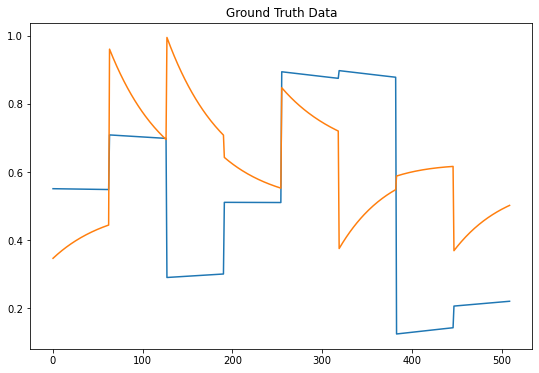

In [58]:
input = x_train[0:510]
plt.plot(input)
plt.title("Ground Truth Data")

Text(0.5, 1.0, 'Koopman AE Output')

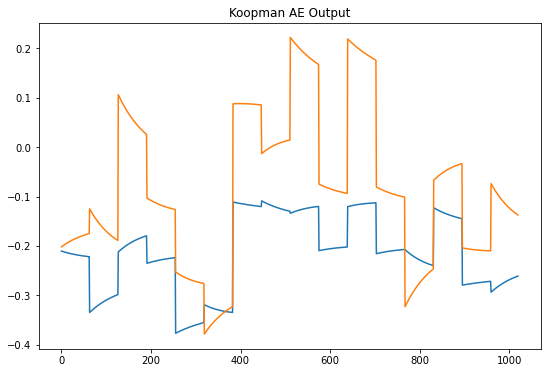

In [91]:
plt.plot(out1)
plt.title("Koopman AE Output")

In [83]:
best_model.save('checkpoints/test_koopman_1')

INFO:tensorflow:Assets written to: checkpoints/test_koopman_1\assets


Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  1168      
_________________________________________________________________
koopman_layer (KoopmanLayer) multiple                  0         
_________________________________________________________________
decoder_model (DecoderModel) multiple                  4802      
Total params: 5,970
Trainable params: 5,970
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'New Model Koopman AE Output')

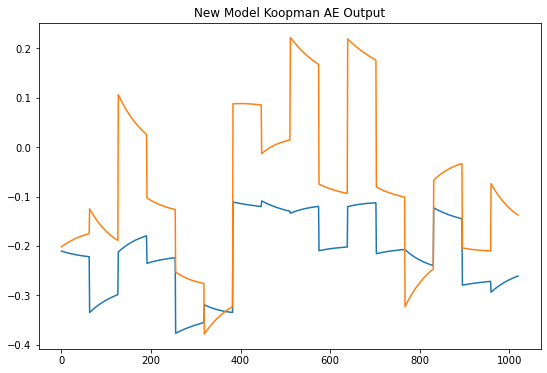

In [92]:
new_model = tf.keras.models.load_model('checkpoints/test_koopman_1', compile=False)
new_model.summary()
new_out1, new_out2 = new_model(x_train)
plt.plot(new_out1)
plt.title("New Model Koopman AE Output")

In [95]:
new_model.koopmanLayer.get_weights

<bound method Layer.get_weights of <keras.saving.saved_model.load.KoopmanLayer object at 0x000001D6491A17C0>>